In [1]:
# Import all required
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from types import SimpleNamespace
plt.style.use(["science", "ieee"])
from gic.model.oml import OceanModel
from gic.model.cables import Cable, TheoriticalSolver
from gic.model.utils import RecursiveNamespace, frexp102str, fft
from gic.validation import SytheticCableAnalysis as SCA

from scipy.stats import pearsonr

In [2]:
#!python simulate.py
ICJ = {
  "sid": 1,
  "opcode": 0,
  "Bfield": {
    "structure": {
      "Am": [
        200,
        90,
        30,
        17,
        8,
        3.5
      ],
      "Tm_min": [
        180,
        80,
        36,
        15,
        8,
        3
      ],
      "Phim": [
        10,
        20,
        30,
        40,
        50,
        60
      ],
      "T_hours": 72
    },
    "tapering": 0.0
  },
  "cable": {
    "cable_sections": [
      {
        "sec_id": None,
        "len_km": 1000,
        "elec_params": {
          "earth_model": "FT1",
          "ocean_depth": 4000,
          "ocean_resistivity": 0.3
        }
      }
    ],
    "cable_pot_plot_index": 0
  },
  "out_dir": "tmp/out/001/",
  "opname": "Synthetic-B"
}

control = RecursiveNamespace(**ICJ)
synb = SCA(control.Bfield, control.cable, out_dir=control.out_dir)
synb.run()

2022-07-29 11:50:00.695 | INFO     | gic.validation.simulate_synB_synT:__init__:52 - Synthetic B-field run parameters
2022-07-29 11:50:00.695 | INFO     | gic.model.synthetic:__init__:105 - Creating B-field data
2022-07-29 11:50:00.775 | INFO     | gic.model.oml:__init__:46 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-07-29 11:50:00.778 | INFO     | gic.validation.simulate_synB_synT:run:98 - Synthetic B FT1->OM(FT1)
2022-07-29 11:50:01.211 | INFO     | gic.validation.simulate_synB_synT:check_analytical_numerical:226 - Corr(Eanl,Enum): 1.0000000000


In [3]:
%matplotlib inline
# Synthetic B-field plot
Bt = synb.ds.field["syn"]
Bt.head()

,X,dTime
0,-20.734236,0.0
1,-20.216802,1.0
2,-19.704925,2.0
3,-19.198687,3.0
4,-18.698168,4.0


In [4]:
# E-field
Et = pd.read_csv("tmp/out/001/Eanl_FT1_h-4000.r-0.30_syn.csv")
Et.head()

,dTime,X
0,0,7.53681
1,1,7.56714
2,2,7.59723
3,3,7.62708
4,4,7.65669


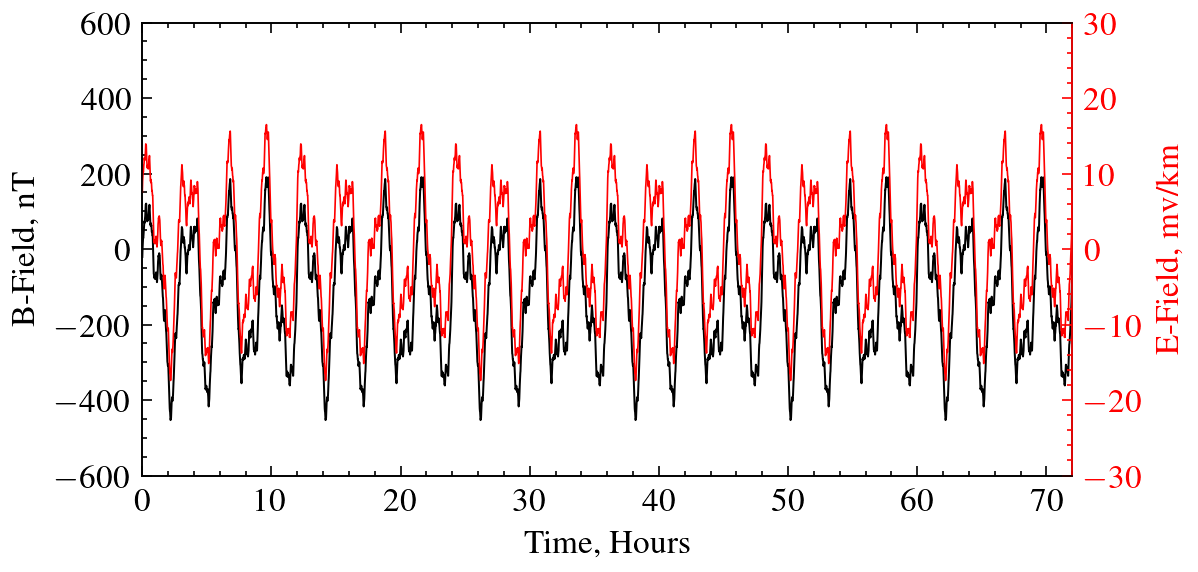

In [5]:
fig = plt.figure(dpi=240, figsize=(5,2.5))
ax = fig.add_subplot(111)
ax.plot(Bt.dTime / 3600.0, Bt.X, ls="-", lw=0.6)
ax.set_xlabel("Time, Hours")
ax.set_ylabel("B-Field, nT")
ax.set_xlim(0, 72)
_ = ax.set_ylim(-600, 600)
ax = ax.twinx()
ax.plot(Et.dTime / 3600.0, Et.X, ls="-", lw=0.5, color="r")
ax.set_ylabel("E-Field, mv/km", color="r")
ax.set_xlim(0, 72)
ax.spines["right"].set_color("red")
ax.tick_params(axis="y", colors="red", which="both")
_ = ax.set_ylim(-30, 30)

In [11]:
Tf = synb.draw_TF_table(synb.ocean_model_list[0])
Ea, Th, m = [], [], 0
for A, P, T in zip(control.Bfield.structure.Am, control.Bfield.structure.Phim, control.Bfield.structure.Tm_min):
    Th.append(P + Tf["Phase (deg)"][m])
    Ea.append(A*np.absolute(Tf["Amplitude (mV/km/nT)"])[m])
    m += 1
print(np.array(Ea).round(2), np.array(Th).round(2))

[10.35  4.86  1.65  0.95  0.45  0.19] [20.66 25.   31.22 36.88 41.93 36.37]
